# Goal

The goal is to compute the projection matrix that goes from world 3D coordinates to 2D image coordinates.

In [2]:
%pylab inline
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


In [3]:
points3d = np.loadtxt('data/task12/pts3d.txt')
points2d_a = np.loadtxt('data/task12/pts2d-pic_a.txt')
points2d_b = np.loadtxt('data/task12/pts2d-pic_b.txt')

pic_a = imread('data/task12/pic_a.jpg')
pic_b = imread('data/task12/pic_b.jpg')

points3d_norm = np.loadtxt('data/task12/pts3d-norm.txt')
points2d_anorm = np.loadtxt('data/task12/pts2d-norm-pic_a.txt')


Let's visualize what points are found as features in our input images.

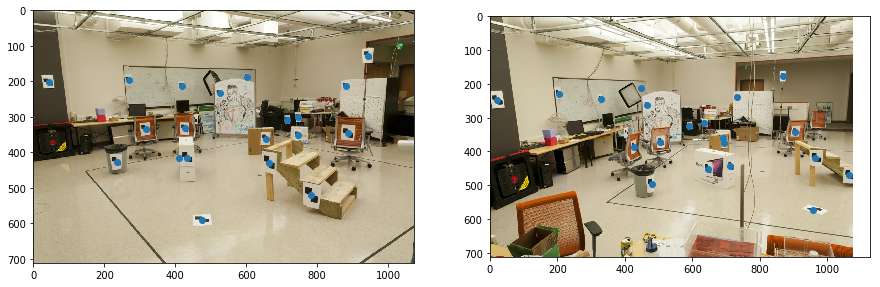

In [4]:
rcParams['figure.figsize'] = 15, 10
subplot(1, 2, 1)
imshow(pic_a)
scatter(points2d_a[:, 0], points2d_a[:, 1])
subplot(1, 2, 2)
imshow(pic_b)
scatter(points2d_b[:, 0], points2d_b[:, 1])

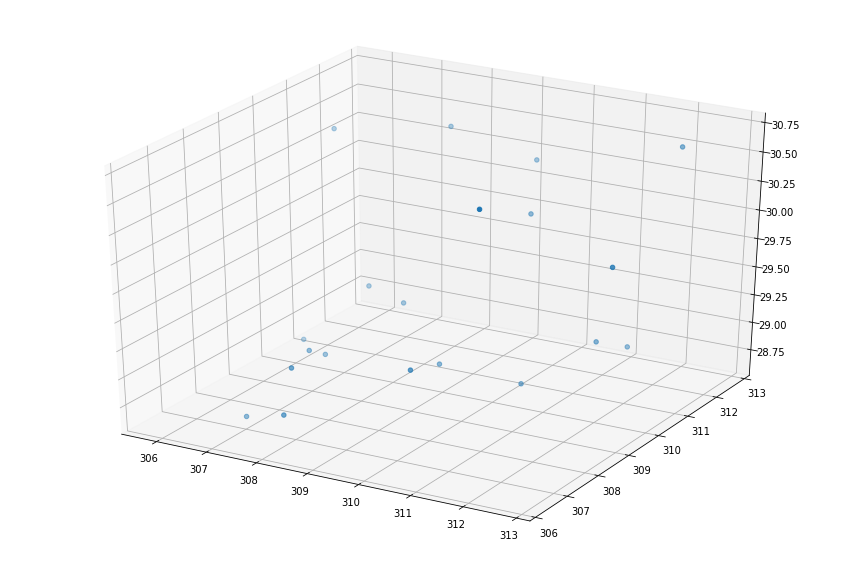

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points3d[:, 0], points3d[:, 1], points3d[:, 2])

First of all, we need to transform our points into homogenous coordinates (keeping the result transposed):

$\left(x, y\right)^{T} = \left\lgroup \matrix{x\cr y\cr 1}\right\rgroup$
$\left(X, Y, Z\right)^{T} = \left\lgroup \matrix{X\cr Y\cr Z\cr 1} \right\rgroup$

In [11]:
def to_hom(points):
    points_hom = np.ones((points.shape[0], points.shape[1] + 1))
    points_hom[:, :points.shape[1]] = points
    return points_hom

points2d_ahom = to_hom(points2d_a)
points2d_bhom = to_hom(points2d_b)
points3d_hom = to_hom(points3d)

points3d_normhom = to_hom(points3d_norm)
points2d_anormhom = to_hom(points2d_anorm)

Now it needs to be put into a system of equations. We'll use SVD decomposition to get the vector of unknown projection matrix values. This vector needs to be then reshaped into an actual projection matrix.

In [16]:
def projection_mat_for(points3d_hom, points2d):
    uvs_2d = points2d.reshape((points2d.shape[0] * points2d.shape[1], 1))
    svd_input = np.zeros((uvs_2d.shape[0], 12))
    for i in range(svd_input.shape[0]):
        point3d_hom = points3d_hom[(i // 2)]
        padding = (4, 0)
        if i % 2 == 0:
            padding = (0, 4)
        
        svd_input[i, :8] = np.pad(point3d_hom, padding, 'constant', constant_values=(0, 0))
        svd_input[i, 8:] = np.repeat(uvs_2d[i], 4) * -1 * point3d_hom
    
    U, S, V = np.linalg.svd(svd_input)
    return V[-1, :].reshape((3, 4))

projection_mat_a = projection_mat_for(points3d_hom, points2d_a)
projection_mat_b = projection_mat_for(points3d_hom, points2d_b)

projection_mat_anorm = projection_mat_for(points3d_normhom, points2d_anorm)

print "Normalized projection matrix: ", projection_mat_anorm


Normalized projection matrix:  [[ 0.45827554 -0.29474237 -0.01395746  0.0040258 ]
 [-0.05085589 -0.0545847  -0.54105993 -0.05237592]
 [ 0.10900958  0.17834548 -0.04426782  0.5968205 ]]


In [14]:
def reproject_3d(points3d_hom, projection_mat):
    projected_2d = np.dot(projection_mat, points3d_hom.T).T
    projected_2d /= np.repeat(projected_2d[:, 2], 3).reshape((projected_2d.shape[0], 3))
    return projected_2d

def reprojection_err(projection_mat, points3d_hom, points2d_hom):
    return np.sum(np.sqrt((reproject_3d(points3d_hom, projection_mat) - points2d_hom) ** 2))
    
print "Reprojection error from 3D to pic A:", reprojection_err(projection_mat_a, points3d_hom, points2d_ahom)
print "Reprojection error from 3D to pic B:", reprojection_err(projection_mat_b, points3d_hom, points2d_bhom)
print "Reprojection error from 3D normalised to pic A normalised:", reprojection_err(projection_mat_anorm, points3d_normhom, points2d_anormhom)

Reprojection error from 3D to pic A: 18.41791559507498
Reprojection error from 3D to pic B: 19.743613715590634
Reprojection error from 3D normalised to pic A normalised: 0.06035367168726946


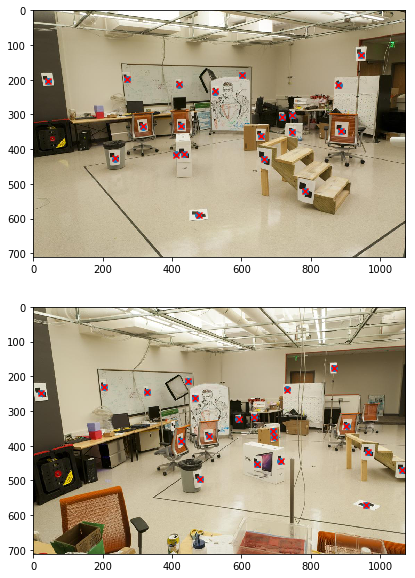

In [15]:
rcParams['figure.figsize'] = 15, 10
points2d_areproj = reproject_3d(points3d_hom, projection_mat_a)
points2d_breproj = reproject_3d(points3d_hom, projection_mat_b)

subplot(2, 1, 1)
imshow(pic_a)
scatter(points2d_a[:, 0], points2d_a[:, 1], marker='o')
scatter(points2d_areproj[:, 0], points2d_areproj[:, 1], marker='x', c='r')
subplot(2, 1, 2)
imshow(pic_b)
scatter(points2d_b[:, 0], points2d_b[:, 1], marker='o')
scatter(points2d_breproj[:, 0], points2d_breproj[:, 1], marker='x', c='r')


We know that projection matrix is composed of upper-triangular matrix (of intrinsic params) and matrix of orthogonal vectors (extrinsic parameters). Remember that, if P is a projection matrix:

$$P = [M | -MC]$$
$$P = K[R | T]$$
$$T = -RC$$

So we can apply RQ decomposition to recover matrices of both intrinsic & extrinsic parameters.

K: 
[[ 0.54497316  0.00130836 -0.00932179]
 [ 0.          0.54466866  0.04059207]
 [ 0.          0.          0.21365823]]
R: 
[[ 0.84995651 -0.5261704  -0.02680746]
 [-0.13139398 -0.16242507 -0.97793339]
 [ 0.5102054   0.83472319 -0.20718987]]
T: 
[ 0.05589805 -0.30433816  2.79334193]
C: 
[-1.51267725 -2.35168754  0.28262819]


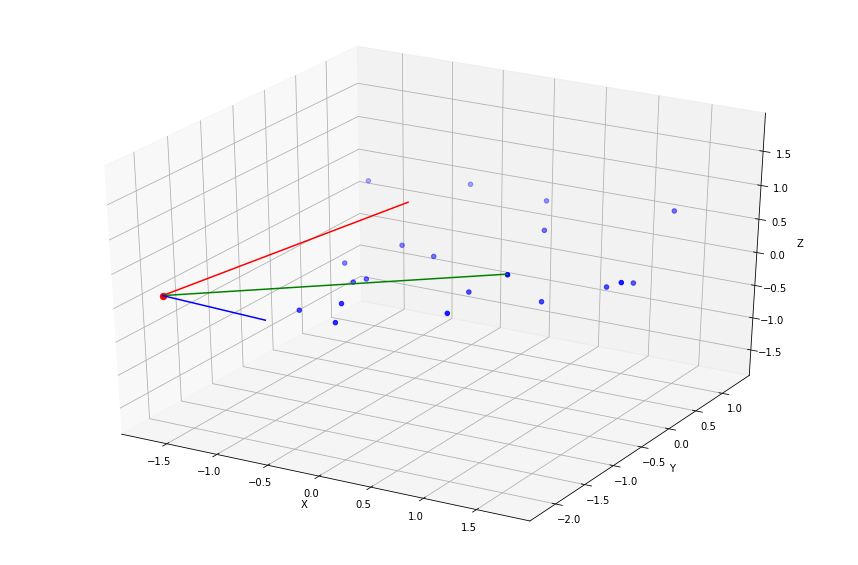

In [92]:
import scipy.linalg

def decompose_projection_mat(projection_mat):
    M = projection_mat[:, :3]
    minus_MC = projection_mat[:, 3]
    
    CameraCenter = -np.dot(np.linalg.inv(M), minus_MC)
    
    Intrinsic, Rotation = scipy.linalg.rq(M)    
    IntrinsicDiagSign = np.diag(np.sign(np.diag(Intrinsic)))
    Intrinsic = np.dot(Intrinsic, IntrinsicDiagSign)
    Rotation = np.dot(Rotation, IntrinsicDiagSign)
    Translation = -1 * np.dot(Rotation, CameraCenter)
    
    return Intrinsic, Rotation, Translation, CameraCenter

K, R, T, C = decompose_projection_mat(projection_mat_anorm)

print "K: \n", K
print "R: \n", R
print "T: \n", T
print "C: \n", C


def plot_camera_position_and_orientation(C, R, points3d):
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
    
#     X, Y, Z = points3d_norm[:, 0], points3d_norm[:, 1], points3d_norm[:, 2]
    
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     ax.scatter(X, Y, Z)
    
#     XRAx = np.array([1.0, 0.0, 0.0]) * R[0, :]
#     XRAx /= np.sqrt(np.sum(XRAx * XRAx))
#     YRAx = np.array([0.0, 1.0, 0.0]) * R[1, :]
#     YRAx /= np.sqrt(np.sum(YRAx * YRAx))
#     ZRAx = np.array([0.0, 0.0, 1.0]) * R[2, :]
#     ZRAx /= np.sqrt(np.sum(ZRAx * ZRAx))
    
#     CRX = C + XRAx
#     CRY = C + YRAx
#     CRZ = C + ZRAx
    
#     ax.plot([C[0], CRX[0]], [C[1], CRX[1]], [C[2], CRX[2]])
#     ax.plot([C[0], CRY[0]], [C[1], CRY[1]], [C[2], CRY[2]])
#     ax.plot([C[0], CRZ[0]], [C[1], CRZ[1]], [C[2], CRZ[2]])
#     ax.scatter(C[0], C[1], C[2], color='r', s=100)
    fig = plt.figure()
    sp = fig.add_subplot(111, projection='3d')
    X,Y,Z = points3d[:,0], points3d[:,1], points3d[:,2]

    X = np.insert(X, 0, C[0])
    Y = np.insert(Y, 0, C[1])
    Z = np.insert(Z, 0, C[2])

    max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()*0.5

    mid_x = (X.max()+X.min()) * 0.5
    mid_y = (Y.max()+Y.min()) * 0.5
    mid_z = (Z.max()+Z.min()) * 0.5

    sp.set_xlim(mid_x - max_range, mid_x + max_range)
    sp.set_ylim(mid_y - max_range, mid_y + max_range)
    sp.set_zlim(mid_z - max_range, mid_z + max_range)
    sp.set_xlabel('X')
    sp.set_ylabel('Y')
    sp.set_zlabel('Z')
    
    CRX = C * R[0, :]
    CRY = C * R[1, :]
    CRZ = C * R[2, :]
    
    sp.plot([C[0], CRX[0]], [C[1], CRX[1]], [C[2], CRX[2]], c='r')
    sp.plot([C[0], CRY[0]], [C[1], CRY[1]], [C[2], CRY[2]], c='g')
    sp.plot([C[0], CRZ[0]], [C[1], CRZ[1]], [C[2], CRZ[2]], c='b')
    
    sp.scatter(X[1:],Y[1:],Z[1:], c='b', marker='o')
    sp.scatter(C[0], C[1], C[2], c='r', marker='o', s=40)

    plt.show()

plot_camera_position_and_orientation(C, R, points3d_norm)